In [46]:
import bson 
import numpy as np
import pandas as pd
import time
import sys
import scipy.sparse
import heapq
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open("linkedin_db/skill.bson",'rb') as f: 
    data_skill = bson.decode_all(f.read()) 
    f.close()

In [4]:
with open("linkedin_db/profile.bson",'rb') as f: 
    data_profile = bson.decode_all(f.read()) 
    f.close()

In [5]:
delete_word = ['de','-','et','&','des','en','du','and','/','of','la','au','in',
                   'à','for','the',':','at','|','le','–','on','to','dans','entreprise',
                   '»', 'En', 'as', 'un','les', 'et','pour','avec']

In [6]:
dict_tran_word = {
    'gestion':'management',
    'stratégie': 'strategy',
    'd\'équipe' : 'team',
    'développement': 'development',
    'commerciale' : 'commercial',
    'réseaux': 'network',
    'réseau':'network',
    'networking':'network',
    'networks'
    'stratégique' : 'strategic',
    'sociaux' : 'social',
    'français':'french',
    'négociations': 'negotiation',
    'négociation':'negotiation',
    'travail':'work',
    'humaines': 'human',
    'droit':'law',
    'financière': 'finance',
    'mobiles':'mobile',
    'vente':'selling',
    'ventes':'selling',
    'publiques': 'public',
    'ingénierie': 'engineering',
    'systèmes':'system',
    'systems':'system',
    'sécurité':'security',
    'd\'énergie':'energy',
    'énergie':'energy',
    'énergétique':'energy',
    'd\'évènement': 'event',
    'd\'évènements':'event',
    'média':'media',
    'médias':'media',
    'd\'entreprise':'enterprise',
    'juridique':'legal',
    'rédaction':'writting',
    'amélioration':'improvement',
    'télécommunications':'telecommunications',
    'logistique':'logistics',
    'intégration':'integration',
    'numérique':'digital',
    'comptabilité':'accounting',
    'financier':'financial',
    'banque':'banking',
    'agiles':'agile',
    'espagnol':'spanish',
    'politique':'policy',
    'politiques':'policy',
    'entrepreneuriat':'entrepreneurship',
    'achats': 'purchasing',
    'modélisation':'modeling',
    'internationales':'internationale',
    'contrôle':'control',
    'controls':'control',
    'technologies':'technology',
    'technique':'technical',
    'contentieux':'litigation',
    'mécanique': 'mechanical',
    'analyses':'analyse',
    'qualité':'quality', 
    'utilisateur':'user',
    'd\'entreprise': 'entreprise',
    'électronique': 'electronics',
    'électrique': 'electrical',
    'vidéo':'video',
    'markets':'market',
    'marché':'market',
    'expérience':'experience',
    'mathématiques':'mathematics',
    'avant-vente': 'pre-sales',
    'databases':'database',
    'renouvelable':'renewable',
    'projet':'project',
    'recrutement':'recruitment',
    'chaîne':'chain',
    'pétrole':'oil',
    'nucléaire':'nuclear',
    'produits':'produit',
    'apprentissage':'learning',
    'embarqués':'embedded',
    'crédit':'credit',
    'compétences':'skills',
    'd\'investissement':'investment',
    'aéronautique':'aviation',
    'opérationnelle':'operational',
    'opérations':'operation',
    'globale': 'global',
    'dérivés': 'derivatives',
    'prévisions':'forecasting',
    'journalisme':'journalism',
    'histoire':'history',
    'aménagement':'planning',
    'aeronautics':'aerospace',
    'création':'creation',
    'étude':'study'
}

In [7]:
skill_list = []
start = time.clock()
for i in range(len(data_profile)):
    if 'skills' in data_profile[i].keys():
        for skills in data_profile[i]['skills']:
            if 'skills' in skills.keys():
                for skill in skills['skills']:
                    for item in skill['title'].split():
                        if item.lower() in delete_word:
                            break
                        if item.lower() in dict_tran_word:
                            skill_list.append(dict_tran_word.get(item.lower()))
                        else:
                            skill_list.append(item.lower())
print(time.clock()-start)

2.1534681706415175


In [8]:
from collections import Counter
num_feature = 500
word_counts = Counter(skill_list)
top_n = word_counts.most_common(num_feature)

In [9]:
feature = []
proportion = []
for i in top_n:
    feature.append(i[0])
    proportion.append(i[1])
coff = 1./np.sqrt(proportion)

In [141]:
import networkx as nx
G = nx.Graph()
G.clear()

In [142]:
start = time.clock()
for f in feature:
    G.add_node(f)
print(time.clock()-start)

0.000986864977676305


In [143]:
start = time.clock()
for data in data_skill:
    if 'name' in data.keys() and 'topSkills' in data.keys():
        skill_name = data['name']
        for name in skill_name.split():
            if name.lower() in dict_tran_word:
                edge1 = dict_tran_word.get(name.lower())
            else:
                edge1 = name.lower()
            if edge1 in feature:
                coff1 = coff[feature.index(edge1)]
                for topskills in data['topSkills']:
                    if 'name' in topskills.keys():
                        for topskill_name in topskills['name'].split():
                            if topskill_name.lower() in dict_tran_word:
                                edge2 = dict_tran_word.get(topskill_name.lower())
                            else:
                                edge2 = topskill_name.lower()
                            if edge2 in feature:
                                coff2 = coff[feature.index(edge2)]
                                if G.has_edge(edge1,edge2):
                                    G[edge1][edge2]['weight'] = G[edge1][edge2]['weight'] + coff1*coff2
                                else:
                                    G.add_edge(edge1, edge2,weight=coff1*coff2)           
print(time.clock()-start)

4.384769094139301


In [127]:
#remove_list = []
#for u in G.nodes():
#    if G.degree(u) == 0:
#        remove_list.append(u)
#for item in remove_list:
#    G.remove_node(item)

11.02434253775209


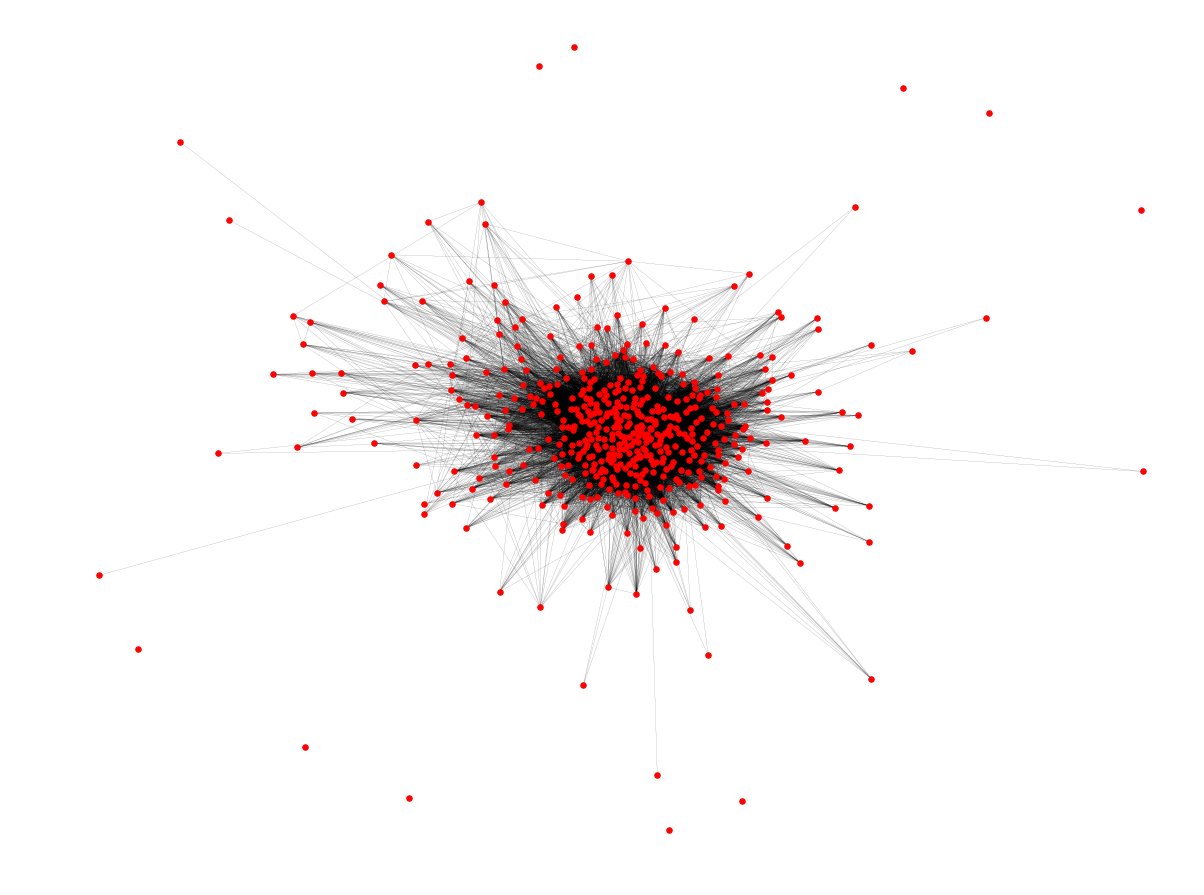

In [144]:
start = time.clock()
plt.figure(figsize=(16,12))
nx.draw(G,with_labels = False, node_size=30, width=0.1)
print(time.clock()-start)

In [147]:
print (nx.info(G))

Name: 
Type: Graph
Number of nodes: 500
Number of edges: 23806
Average degree:  95.2240


In [170]:
start = time.clock()
skill_ontology_matrix = np.zeros((num_feature, num_feature))
for i in range(num_feature):
    f = feature[i]
    for u in G.neighbors(f):
        j = feature.index(u)
        skill_ontology_matrix[i,j] = G[f][u]['weight']
print(time.clock()-start)

0.39017986384624237


In [171]:
df = pd.DataFrame(data=[],index=[],columns=feature)
start = time.clock()
array = scipy.sparse.lil_matrix((len(data_profile), len(feature)))
top_effect = 10
for i in range(len(data_profile)):
    rang = np.zeros(len(feature))
    effect = 1
    if 'skills' in data_profile[i].keys():
        for skills in data_profile[i]['skills']:
            if 'skills' in skills.keys():
                if skills['title'] == 'Top Skills':
                    effect = top_effect
                else:
                    effect = 1
                for skill in skills['skills']:
                    for item in skill['title'].split():
                        if item.lower() in dict_tran_word:
                            item = dict_tran_word.get(item.lower())
                        if item.lower() in feature:
                            index = feature.index(item.lower())
                            array[i,index] = max(array[i,index],1 * effect)
df = pd.DataFrame(data=array.A, columns=feature)
print(time.clock()-start)

18.357202060011332


In [265]:
def match(df, index, n_output, ontology=False, coff_ontology=1):
    loss = 0.01
    sample = df.loc[index].values
    if ontology:
        sample
        sample = coff * (sample + coff_ontology * sample.dot(skill_ontology_matrix))
    else:
        sample = coff * sample
    if sum(sample) == 0:
        print('This profile doesn\'t have skill.')
    sample = sample - loss*(sample==0)
    score = df.values.dot(sample)
    score = list(score)
    max_index = heapq.nlargest(n_output, range(len(score)), score.__getitem__)
    return max_index

In [266]:
def show_skill(index):
    show = [[],[]]
    show[0].append('Top Skills: ')
    show[1].append('Other Skills: ')
    for skills in data_profile[index]['skills']:
        if skills['title'] == 'Top Skills':
            for skill in skills['skills']:
                show[0].append(skill['title'])
        else:
            for skill in skills['skills']:
                show[1].append(skill['title'])
    print(show[0])
    print(show[1])
    return

In [221]:
match(df, 31929, 3, ontology=True)

[29624, 9013, 16619]

In [177]:
show_skill(31929)

['Top Skills: ', 'Science actuarielle', 'Statistiques', 'R']
['Other Skills: ', 'SAS', 'Visual Basic pour Applications (VBA)', 'Microsoft Access', 'Microsoft Office']


In [213]:
show_skill(30380)

['Top Skills: ', 'Statistiques', 'R', 'SAS']
['Other Skills: ', 'VBA', 'Microsoft Excel', 'Microsoft Access']


In [222]:
#ontology
show_skill(29624)

['Top Skills: ', 'Food Microbiology', 'Environmental Microbiology', 'University Teaching']
['Other Skills: ', 'Grant Writing', 'Course Creation', 'Experimental Design']


In [223]:
show_skill(9013)

['Top Skills: ', 'Building Materials', 'Environmental Engineering', 'Structural Engineering']
['Other Skills: ', 'Project Engineering', 'BIM', 'Fluid Mechanics', 'Software Engineering', 'Modeling', 'CAD', 'Product Lifecycle Management', 'Systems Engineering', 'Mechanical Engineering', 'AutoCAD Architecture', 'Autodesk Revit', 'Catia', 'Solidworks', 'SketchUp', 'PHP', 'HTML', 'CSS3', 'MySQL', 'Java', 'C++ Language', 'Matlab', 'SolidWorks', 'CATIA', 'Urbanism']


In [224]:
show_skill(16619)

['Top Skills: ', 'Ingénierie', 'Environmental Science', 'Landscape Design']
['Other Skills: ', 'Landscape Architecture', 'Sustainable Development', 'Microsoft Word', 'Microsoft Office', 'PowerPoint', 'Microsoft Excel', 'Management', 'Développement durable', 'Creative Conception', 'Gestion de projet', "Gestion d'évènement", 'Landscape Photography', 'Landscape Maintenance', 'Anglais', 'Parler en public', 'Service client', 'Sociability', 'Recherche', 'Planification stratégique', 'Réseaux sociaux']


In [285]:
match(df, 26374, 3, ontology=True, coff_ontology = 100)

[2691, 14343, 10624]

In [268]:
show_skill(11103)

['Top Skills: ', 'Énergie', 'Microsoft Excel', 'Nuclear Engineering']
['Other Skills: ', 'Java', 'Python', 'Nuclear Physics', 'MCNP', 'Open Office', 'DIF3D']


In [269]:
show_skill(11131)

['Top Skills: ', 'Nuclear Safety', 'Nuclear Engineering', 'Power Plants']
['Other Skills: ', 'Thermodynamics', 'Energy', 'Power Generation', 'Project Engineering', 'Hazard Analysis', 'Engineering', 'Project Management', 'Matlab', 'Microsoft Office', 'English', 'Reactor', 'Stochastic Simulation', 'Monte Carlo Simulation']


In [270]:
show_skill(12375)

['Top Skills: ', 'Renewable Energy', 'Power Systems', 'Nuclear']
['Other Skills: ', 'Gestion de projet', 'Energy', 'Strategy', 'Project Management', 'Smart Grid', 'Wind Energy', 'Electrical', 'Electrical Engineering', 'Ingénierie', 'Énergie renouvelable', 'Énergie', 'Matlab', 'Electricity Markets', 'System Planning']


In [283]:
show_skill(26374)

['Top Skills: ', 'Gestion de Projet', 'HTML5', 'css']
['Other Skills: ', 'Développement iOS', 'JavaScript', 'PHP', 'jQuery', 'Twitter Bootstrap', 'AJAX', 'Symfony', 'Developpement Web']


In [286]:
show_skill(2691)

['Top Skills: ', 'Environmental Impact Assessment', 'Environmental Management Systems', 'Environmental Awareness']
['Other Skills: ', 'Sustainability', 'Waste Management', 'Environmental Science', 'Environmental Policy', 'Water', 'Sustainable Development', 'Environmental Consulting', 'Environmental Engineering', 'Climate Change', 'Project Management', 'Environmental Compliance', 'Water Resources', 'Data Analysis', 'Water Resource Management', 'Business Analysis', 'Project Planning', 'International Project Management', 'Corporate Social Responsibility', 'Environmental Auditing', 'Air Quality', 'International Management']
